# Focus On Cuisines

In [74]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns 
import math 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys
sys.path.append('../Functions')
import CleanUp as p



## 1 cleanUp()

In [75]:
filepath = '../Data/DM2425_ABCDEats_DATASET.csv'
# Load the raw data
raw_data = pd.read_csv(filepath)
df, columns_dict = p.cleanUp(raw_data)

-----------looking for incostisencies -----------
There are repeated values in the dataset
      customer_id customer_region  customer_age  vendor_count  product_count  \
20855  742ca068fc            8550          20.0             1              2   
20907  742ca068fc            8550          20.0             1              2   

       is_chain  first_order  last_order last_promo payment_method  ...  \
20855         0         35.0          35          -           CARD  ...   
20907         0         35.0          35          -           CARD  ...   

       HR_14  HR_15  HR_16  HR_17  HR_18  HR_19  HR_20  HR_21  HR_22  HR_23  
20855      0      0      0      0      0      0      0      0      0      0  
20907      0      0      0      0      0      0      0      0      0      0  

[2 rows x 56 columns]
-----------identify the numerical columns -----------
primary_key is not numerical
-----------identify the non numerical columns -----------
primary_key is non numerical
-------------- 

In [76]:
df.head()

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,used_promo,order_count,avg_product_by_order,delta_day_order,tot_value_cui,order_freq,value_freq,product_freq,avg_order_value,avg_product_value
0,1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,...,True,2,2.5,2.0,28.88,1.000000,14.440,2.500000,5.776,5.776
1,5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,...,True,2,1.0,2.0,19.21,1.000000,9.605,1.000000,9.605,9.605
2,f6d1b2ba63,4660,38.0,1,2,2,0.0,1,DISCOUNT,CASH,...,True,2,1.0,2.0,9.20,1.000000,4.600,1.000000,4.600,4.600
3,180c632ed8,4660,NaN,2,3,1,0.0,2,DELIVERY,DIGI,...,True,2,1.5,3.0,31.56,0.666667,10.520,1.000000,10.520,10.520
4,4eb37a6705,4660,20.0,2,5,0,0.0,2,No_Promo,DIGI,...,False,2,2.5,3.0,55.44,0.666667,18.480,1.666667,11.088,11.088


### 1.1 extract the necessary columns

In [77]:
key = columns_dict.keys()
print(key)
new_features_list = columns_dict['new_features_list']
numerical_columns = columns_dict['numerical_columns']
CUI_col = columns_dict['CUI_col']
HR_col = columns_dict['HR_col']
DOW_col = columns_dict['DOW_col']

dict_keys(['non_numerical_columns', 'new_features_list', 'numerical_columns', 'CUI_col', 'HR_col', 'DOW_col'])


## 2 find the value and the total value per cuisine

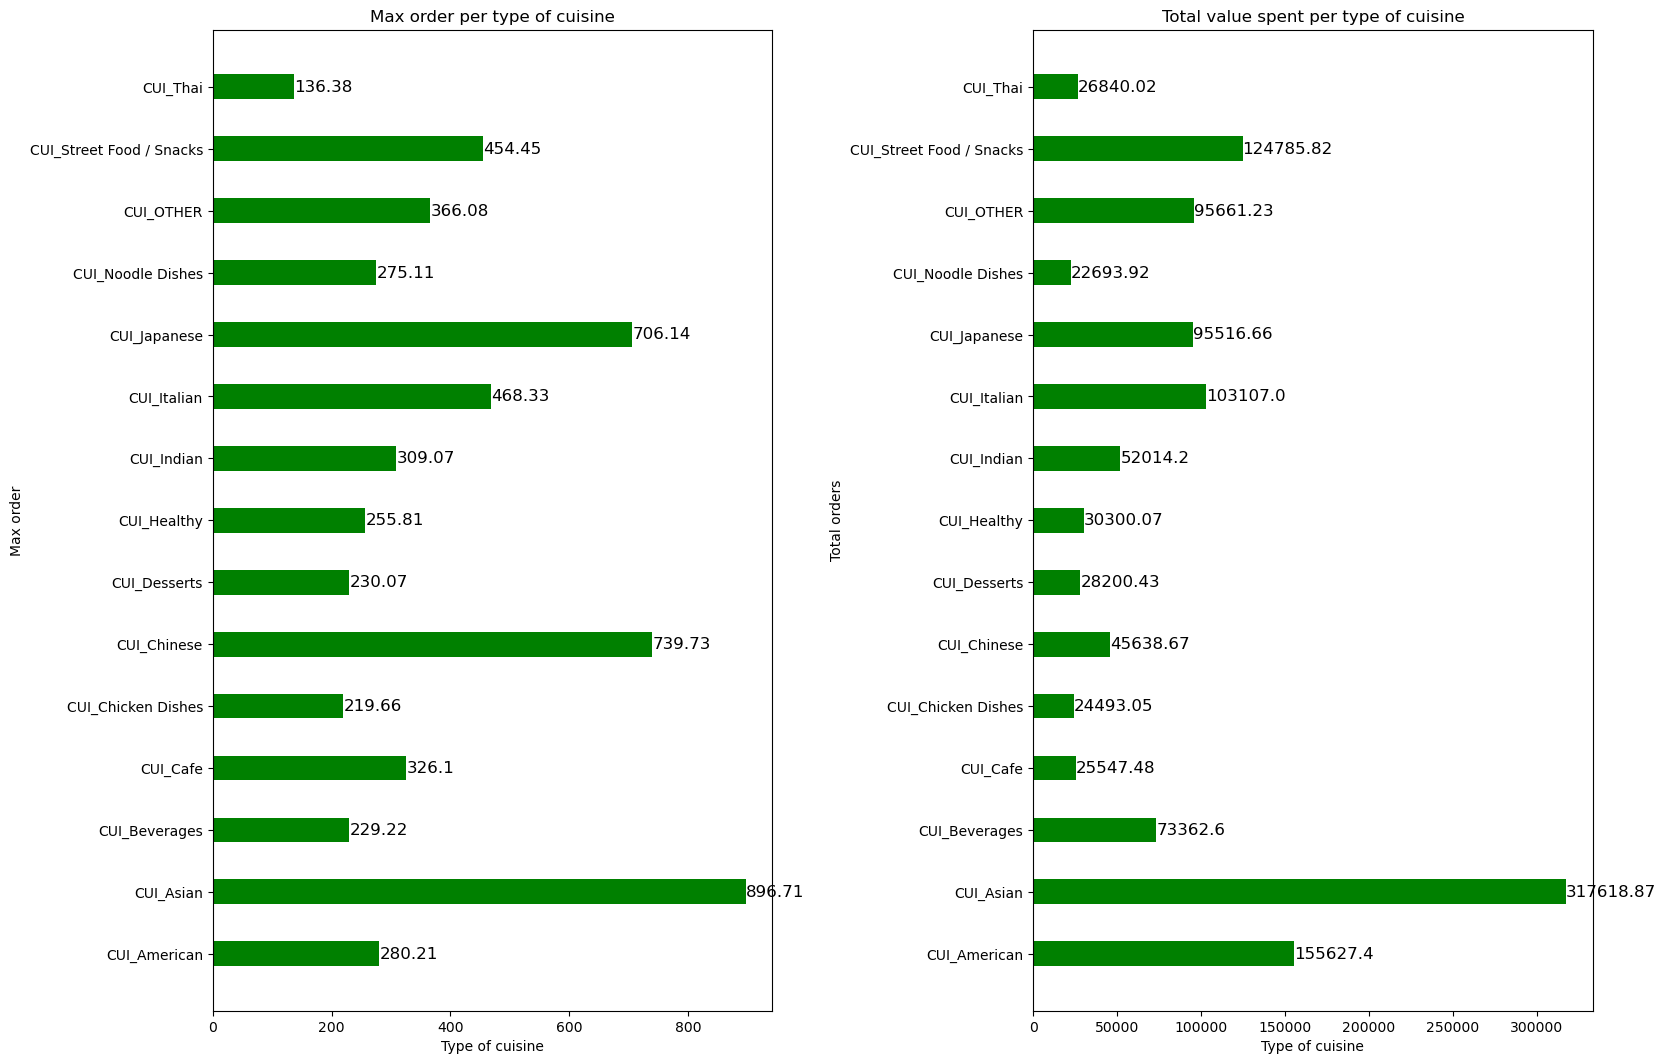

In [78]:
max_values = df[CUI_col].max()
sum_values = df[CUI_col].sum().round(2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 11))

axes[0].barh(max_values.index, max_values.values, color='green', height=0.4)
axes[0].set_title('Max order per type of cuisine')
axes[0].set_xlabel('Type of cuisine')
axes[0].set_ylabel('Max order')
for i in range(len(max_values)):
    axes[0].text(max_values.values[i] + 1, i, str(max_values.values[i]), va='center', fontsize=12)

axes[1].barh(sum_values.index, sum_values.values, color='green', height=0.4)
axes[1].set_title('Total value spent per type of cuisine')
axes[1].set_xlabel('Type of cuisine')
axes[1].set_ylabel('Total orders')
for i in range(len(sum_values)):
    axes[1].text(sum_values.values[i] + 1, i, str(sum_values.values[i]),va='center', fontsize=12)

plt.tight_layout(pad=2.0)
plt.show()

## 3 count the zeroes of the CUI_col and plot the result


In [79]:
is_zero = (df[CUI_col] == 0).sum().sum()
is_non_zero = (df[CUI_col] != 0).sum().sum()

l = [is_zero,is_non_zero]
l

[405773, 72547]

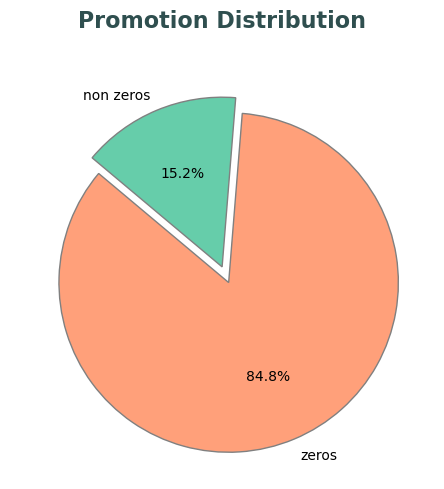

In [80]:
# Adjusted colors
colors = ['lightsalmon', 'mediumaquamarine']

# Configuring the pie chart with labels and highlighting the most relevant slice
plt.figure(figsize=(10, 5))  # Setting figure size
plt.pie(l, 
        colors=colors, 
        labels=["zeros","non zeros"],  # Labels for each slice
        autopct='%1.1f%%',  # Percentages on each slice
        startangle=140,  # Starting angle for better layout
        explode=(0.1, 0),  # Highlight the first slice (adjust as needed)
        wedgeprops={'edgecolor': 'gray'})  # Gray borders for contrast

# Chart title
plt.title("Promotion Distribution", fontsize=16, fontweight='bold', color='darkslategray', pad=20)

# Displaying the chart
plt.tight_layout()
plt.show()

## 4 outliers count

In [81]:
def count_outliers_for_columns(df, column_names):
    """
    Count the number of outliers for each specified column in a DataFrame using the IQR method.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_names (list): A list of column names to analyze.

    Returns:
    list: A list of tuples where each tuple contains the column name and the number of outliers.
    """
    outliers_count_list = []

    for column_name in column_names:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)

        # Calculate IQR (Interquartile Range)
        IQR = Q3 - Q1

        # Define outliers as values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count the outliers
        outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
        outlier_count = outliers.shape[0]

        # Append the result as a tuple (column_name, outlier_count)
        x = "{p}%".format(p = int(outlier_count/df.shape[0]*1000)/10)
        outliers_count_list.append((column_name, outlier_count,x))

    return outliers_count_list

# Example usage:
# Assuming df is your DataFrame and you have a list of column names
outliers_counts = count_outliers_for_columns(df, CUI_col)

for col in outliers_counts:
    print(col)

('CUI_American', 3511, '11.0%')
('CUI_Asian', 3475, '10.8%')
('CUI_Beverages', 5435, '17.0%')
('CUI_Cafe', 1366, '4.2%')
('CUI_Chicken Dishes', 3248, '10.1%')
('CUI_Chinese', 3522, '11.0%')
('CUI_Desserts', 2016, '6.3%')
('CUI_Healthy', 2169, '6.8%')
('CUI_Indian', 3448, '10.8%')
('CUI_Italian', 6448, '20.2%')
('CUI_Japanese', 6301, '19.7%')
('CUI_Noodle Dishes', 2226, '6.9%')
('CUI_OTHER', 7041, '22.0%')
('CUI_Street Food / Snacks', 4249, '13.3%')
('CUI_Thai', 2378, '7.4%')


##  5 Distribution of the cuisines by region 

### 5.1 radars

#### 5.1.1 Regions

#### 5.1.2 Cities

In [90]:
cities = df["customer_city"].dropna().unique()

# Adjust the number of rows and columns based on the number of cities
num_cities = len(cities)
rows = math.ceil(num_cities / 3)
cols = min(num_cities, 3)

fig = make_subplots(rows=rows, cols=cols, specs=[[{'type': 'polar'}]*cols]*rows, subplot_titles=[f'City {city}' for city in cities])

for i, city in enumerate(cities):
    df_city = df[df["customer_city"] == city]
    total = df_city[CUI_col].sum(axis=0)
    
    CUI_col_sum = df_city[CUI_col].sum(axis=0)
    CUI_col_sum.sort_values(ascending=True, inplace=True)
    CUI_cumperc = CUI_col_sum.cumsum()/CUI_col_sum.sum()
    CUI_cumperc = CUI_cumperc[CUI_cumperc > 0]
    CUI_cumperc = CUI_cumperc.index
    
    theta = total.index
    count = 1
    new_theta = []
    for t in theta:
        if t in CUI_cumperc:
            new_theta.append(t)
        else:
            new_theta.append(' ' * count)
            count += 1
    theta = new_theta    
    
    radar = pd.DataFrame(dict(r=total, theta=theta))
    row = (i // cols) + 1
    col = (i % cols) + 1
    fig.add_trace(px.line_polar(radar, r='r', theta='theta', line_close=True).data[0], row=row, col=col)

# Adjust annotations to move the titles up
for annotation in fig['layout']['annotations']:
    annotation['y'] = annotation['y'] + 0.1  # Increase this value to move the titles up

fig.update_layout(height=600, width=1800, title_text="Radar Charts for Each City", title_y=0.99)
fig.show()

### 5.2 Heatmaps

#### 5.2.1 Regions

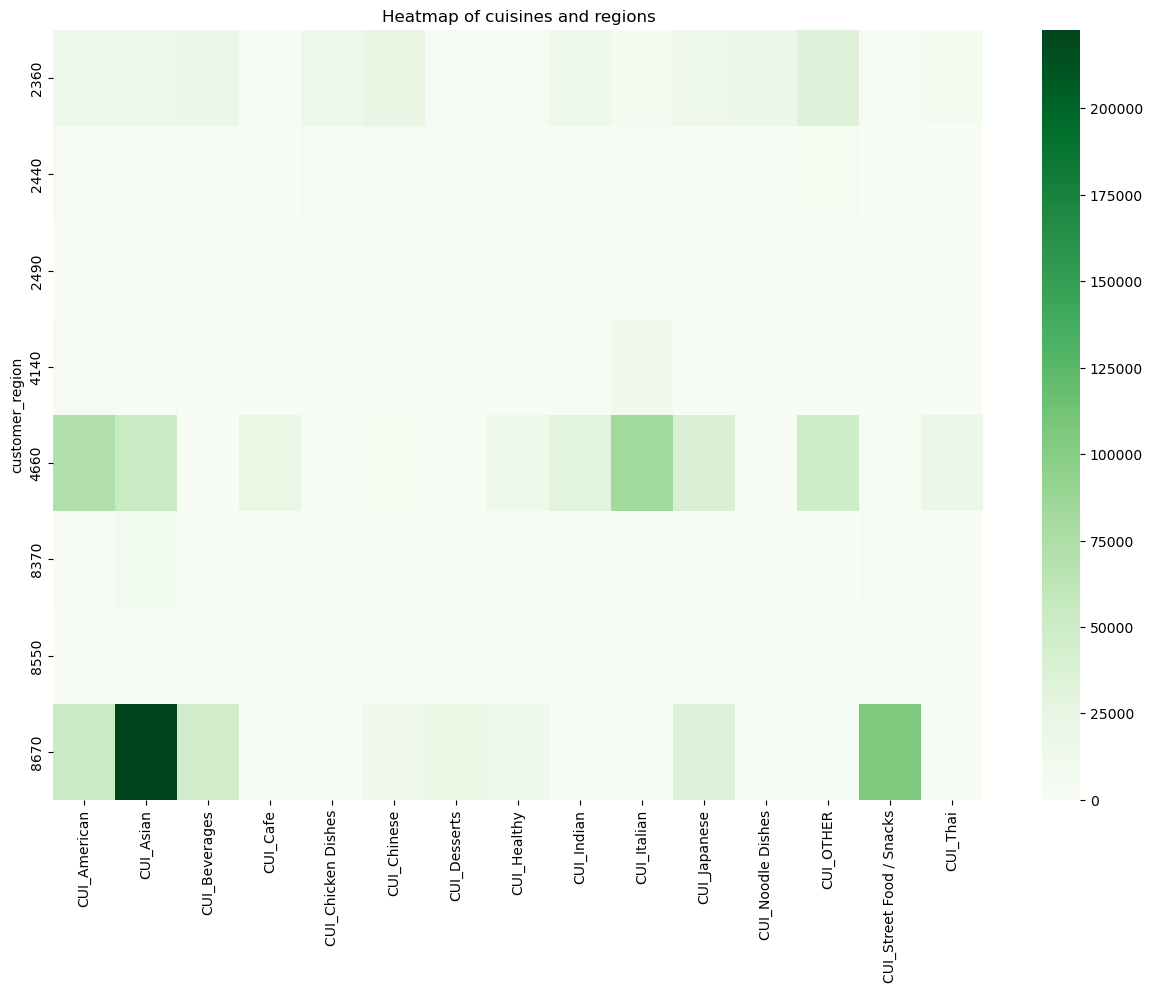

In [15]:
# make a heatmap of cuisines and region
df_region = df.groupby('customer_region')[CUI_col].sum()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_region, cmap= 'Greens', ax=ax)
plt.title('Heatmap of cuisines and regions')
plt.show()

#### 5.2.2 Cities

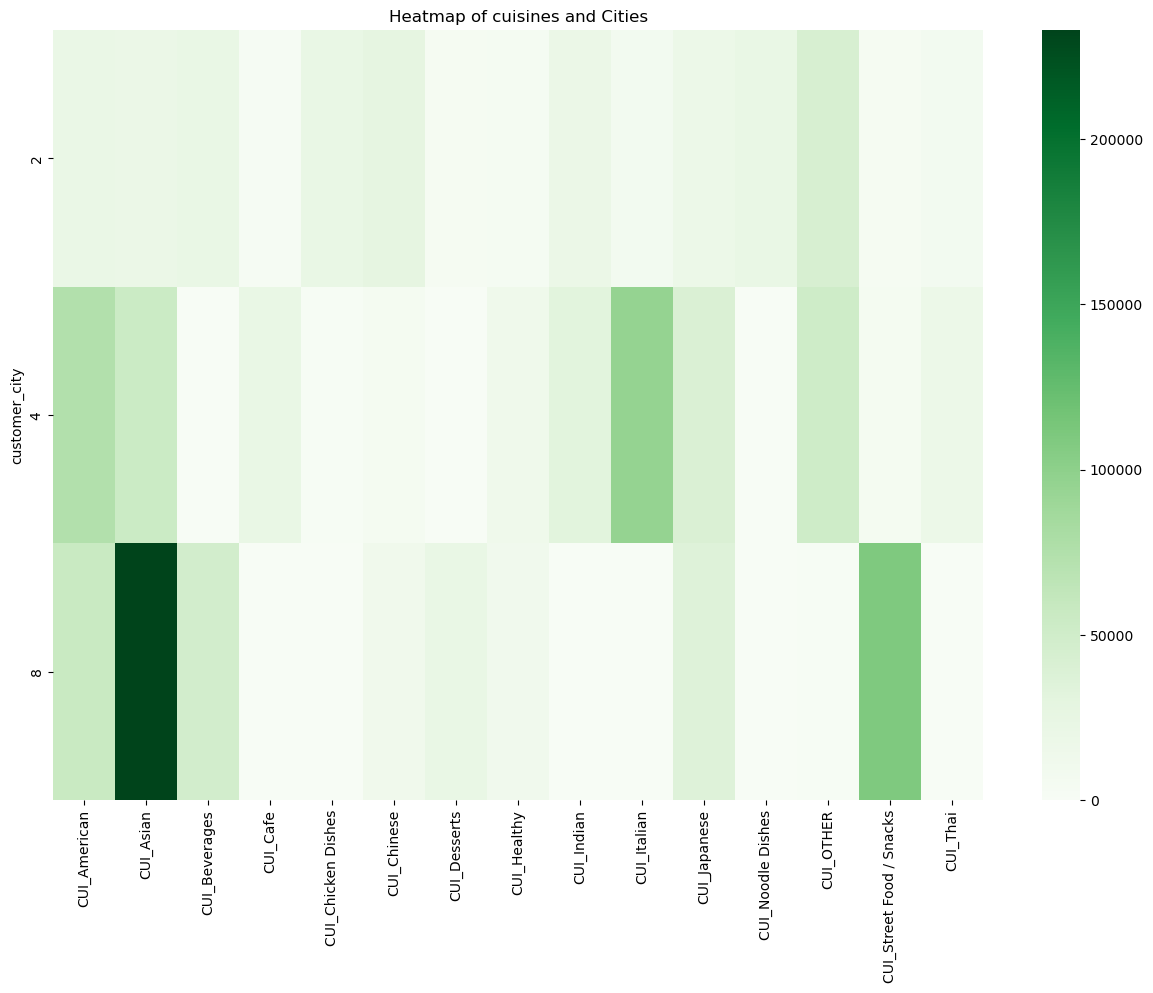

In [91]:
# make a heatmap of cuisines and region
df_city = df.groupby('customer_city')[CUI_col].sum()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_city, cmap= 'Greens', ax=ax)
plt.title('Heatmap of cuisines and Cities')
plt.show()

#### different approach